## Packages

In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
!pip install arch
from arch import arch_model
!pip install yfinance
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 18.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 899 kB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 6.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_csv_data = pd.read_excel("/content/drive/MyDrive/Index3 excel.xlsx",header=2)
df_comp=raw_csv_data.copy()


df_comp['log'] = np.log( df_comp.Close)


df_comp.date = pd.to_datetime(df_comp.Date, dayfirst = True)
df_comp.set_index("Date", inplace=True)
# df_comp=df_comp.asfreq('b')
# df_comp=df_comp.fillna(method='ffill')

df_comp['IPC']=df_comp.Close

df_comp.head()


,Close,log,IPC
Date,,,
2021-01-04,44703.00,10.707796,44703.00
2021-01-05,44908.12,10.712374,44908.12
2021-01-06,45587.16,10.727381,45587.16
2021-01-07,46188.66,10.740490,46188.66
2021-01-08,46729.30,10.752127,46729.30


## Prueba de estacionalidad

In [ ]:
adf_test= ADFTest(alpha=0.05)
adf_test.should_diff(df_comp.Close)

(0.4076294302933626, True)

## Creating Returns

In [ ]:
df_comp['ret_IPC'] = df_comp.IPC.pct_change(1).mul(100)
df_comp.head()

,Close,log,IPC,ret_IPC
Date,,,,
2021-01-04,44703.00,10.707796,44703.00,NaN
2021-01-05,44908.12,10.712374,44908.12,0.458851
2021-01-06,45587.16,10.727381,45587.16,1.512065
2021-01-07,46188.66,10.740490,46188.66,1.319450
2021-01-08,46729.30,10.752127,46729.30,1.170504


In [ ]:
df_comp['norm_ret_IPC'] = df_comp.ret_IPC.div(df_comp.IPC[1])*100
df_comp.head()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-01-04,44703.00,10.707796,44703.00,NaN,NaN
2021-01-05,44908.12,10.712374,44908.12,0.458851,0.001022
2021-01-06,45587.16,10.727381,45587.16,1.512065,0.003367
2021-01-07,46188.66,10.740490,46188.66,1.319450,0.002938
2021-01-08,46729.30,10.752127,46729.30,1.170504,0.002606


## Splitting the Data

In [61]:
size = int(len(df_comp.log)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df.head()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-01-04,44703.00,10.707796,44703.00,NaN,NaN
2021-01-05,44908.12,10.712374,44908.12,0.458851,0.001022
2021-01-06,45587.16,10.727381,45587.16,1.512065,0.003367
2021-01-07,46188.66,10.740490,46188.66,1.319450,0.002938
2021-01-08,46729.30,10.752127,46729.30,1.170504,0.002606


In [ ]:
df.tail()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-08-19,51099.36,10.841527,51099.36,-1.705687,-0.003798
2021-08-20,51414.32,10.847672,51414.32,0.616368,0.001373
2021-08-23,52054.64,10.860049,52054.64,1.245412,0.002773
2021-08-24,51985.00,10.858710,51985.00,-0.133783,-0.000298
2021-08-25,52345.39,10.865619,52345.39,0.693258,0.001544


In [ ]:
df_test.head()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-08-26,52290.69,10.864574,52290.69,-0.104498,-0.000233
2021-08-27,52425.64,10.867151,52425.64,0.258077,0.000575
2021-08-30,52602.07,10.870511,52602.07,0.336534,0.000749
2021-08-31,53304.74,10.883781,53304.74,1.335822,0.002975
2021-09-01,52215.54,10.863135,52215.54,-2.043345,-0.004550


In [ ]:
df_test.tail()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-10-18,52686.03,10.872106,52686.03,-0.212791,-0.000474
2021-10-19,52402.73,10.866714,52402.73,-0.537714,-0.001197
2021-10-20,52298.20,10.864717,52298.20,-0.199474,-0.000444
2021-10-21,52020.05,10.859385,52020.05,-0.531854,-0.001184
2021-10-22,51889.66,10.856875,51889.66,-0.250653,-0.000558


## Fitting a Model

In [62]:
model_ar = ARIMA(df.log, order = (1,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    log   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                 532.962
Method:                       css-mle   S.D. of innovations              0.009
Date:                Wed, 17 Nov 2021   AIC                          -1059.923
Time:                        23:41:59   BIC                          -1050.624
Sample:                             0   HQIC                         -1056.148
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7861      0.044    243.924      0.000      10.699      10.873
ar.L1.log      0.9886      0.011     90.807      0.000       0.967       1.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0116           +0.0000j            1.0116            0.0000
-----------------------------------------------------------------------------
"""

## Simple Forecasting

In [ ]:
df.tail()

,Close,log,IPC,ret_IPC,norm_ret_IPC
Date,,,,,
2021-08-19,51099.36,10.841527,51099.36,-1.705687,-0.003798
2021-08-20,51414.32,10.847672,51414.32,0.616368,0.001373
2021-08-23,52054.64,10.860049,52054.64,1.245412,0.002773
2021-08-24,51985.00,10.858710,51985.00,-0.133783,-0.000298
2021-08-25,52345.39,10.865619,52345.39,0.693258,0.001544


In [ ]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2021-01-04"
end_date = "2021-08-25"

In [ ]:
df_pred = results_ar.predict(start = start_date, end = end_date)

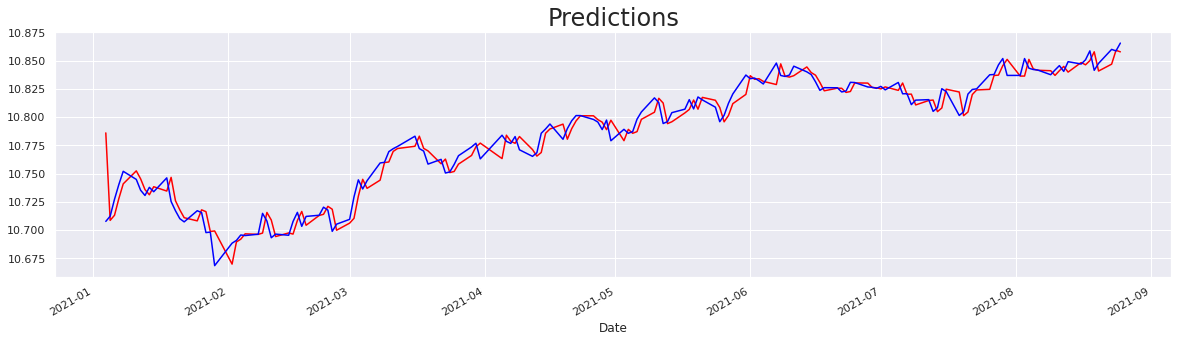

In [ ]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df.log[start_date:end_date].plot(color="blue")
plt.title("Predictions", size = 24)
plt.show()

### SARIMAX

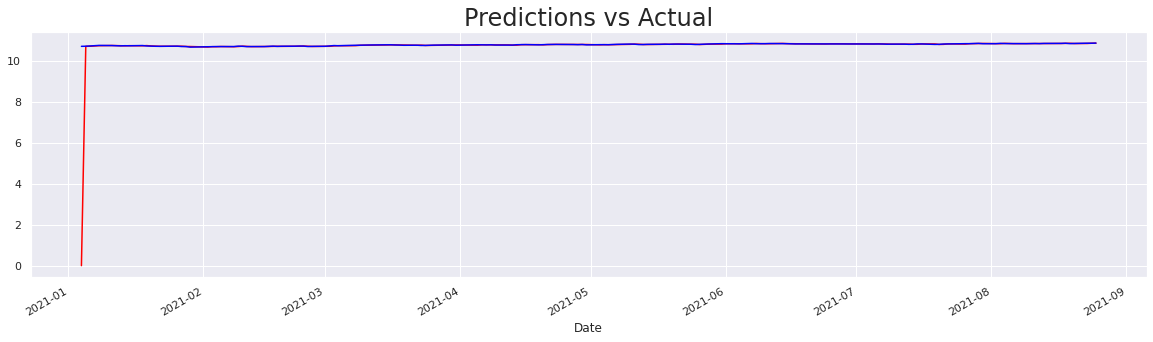

In [126]:
start_date="2021-01-04"
end_date="2021-08-25"


model_sarimax = SARIMAX(df.log, exog = None, order = (4,1,4), seasonal_order = (0,0,0,0))
results_sarimax = model_sarimax.fit()

df_pred_sarimax = results_sarimax.predict(start = start_date, end = end_date, exog=None)

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df.log[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [98]:
model_auto = auto_arima(df.log, start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, D=1, max_P=5, max_Q=5, max_D=5, m=1, trace=True,stepwise=True, 
                         random_state=20, n_fits=50, criterion="aic", alpha=0.05,seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1060.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1060.076, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1060.403, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1060.575, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1061.501, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1058.915, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1057.411, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1059.846, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1058.985, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1056.320, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1057.360, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.901 seconds


In [101]:
start_date="2021-08-26"
end_date="2021-10-22"

df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test.log[start_date:end_date])), index = df_test.log[start_date:end_date].index)

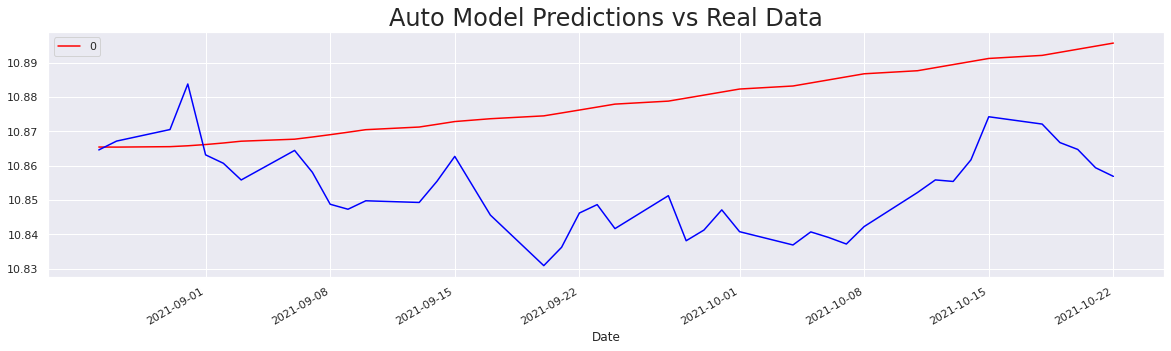

In [102]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.log[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Forecasting Volatility

In [ ]:
mod_garch = arch_model(df_comp.ret_IPC[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     67,   Neg. LLF: 219.27756163124553
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 219.27753777409612
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11


In [ ]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

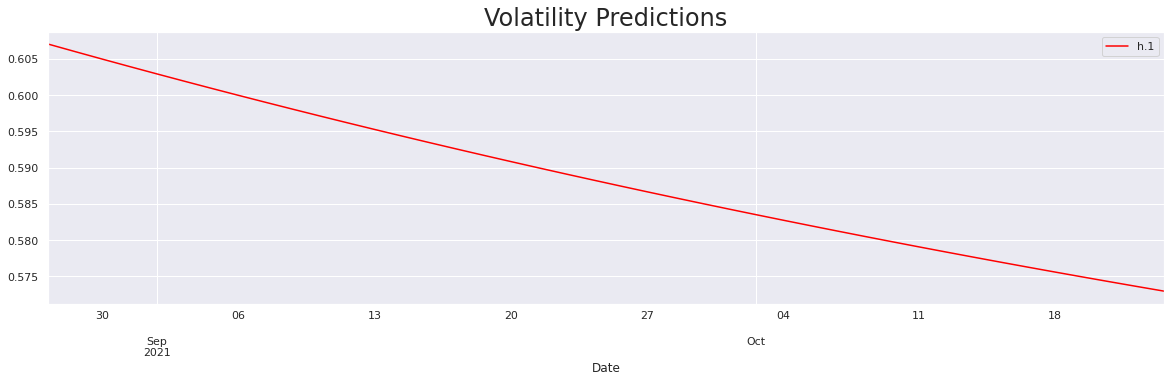

In [ ]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
plt.title("Volatility Predictions", size = 24)
plt.show()

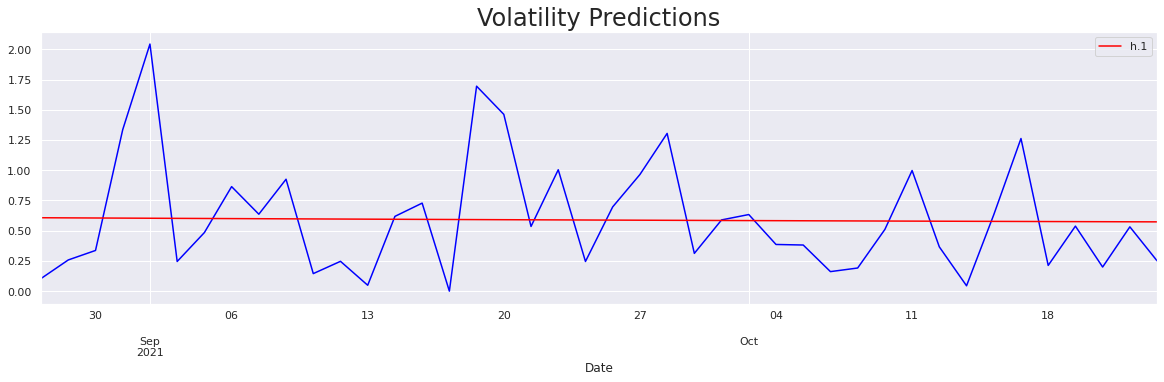

In [ ]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_IPC.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [ ]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,h.011,h.012,h.013,h.014,h.015,h.016,h.017,h.018,h.019,h.020,h.021,h.022,h.023,h.024,h.025,h.026,h.027,h.028,h.029,h.030,h.031,h.032,h.033,h.034,h.035,h.036,h.037,h.038,h.039,h.040,...,h.061,h.062,h.063,h.064,h.065,h.066,h.067,h.068,h.069,h.070,h.071,h.072,h.073,h.074,h.075,h.076,h.077,h.078,h.079,h.080,h.081,h.082,h.083,h.084,h.085,h.086,h.087,h.088,h.089,h.090,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,1.142407,1.121338,1.036393,1.11072,1.183629,1.257723,1.248608,1.336788,1.395024,1.014502,0.65149,0.691586,0.683082,0.701209,0.509165,0.491619,0.510821,0.490371,0.49208,0.512208,0.531597,0.528003,0.524606,0.523109,0.536405,0.555709,0.569648,0.590162,0.609764,0.63289,...,0.779928,0.790801,0.816335,0.836243,0.860533,0.85355,0.873285,0.827,0.8511,0.878126,0.888177,0.808246,0.829919,0.85095,0.859692,0.883821,0.883548,0.883613,0.855375,0.8605,0.882306,0.865465,0.886742,0.777604,0.790476,0.798239,0.800314,0.802961,0.810827,0.823701,0.837281,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


### Multivariate Regression Model

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
df_ret = df['ret_IPC'][1:]

In [ ]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

ValueError: ignored

In [ ]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Apr, 2020
Time:                     07:48:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

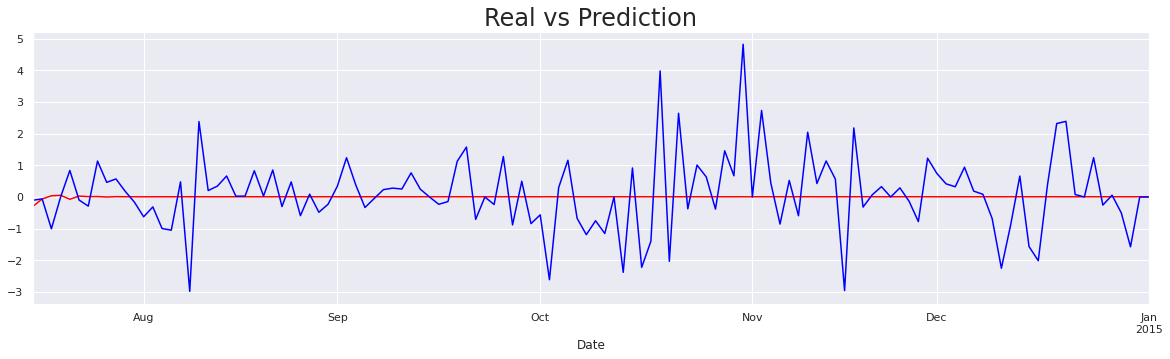

In [ ]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

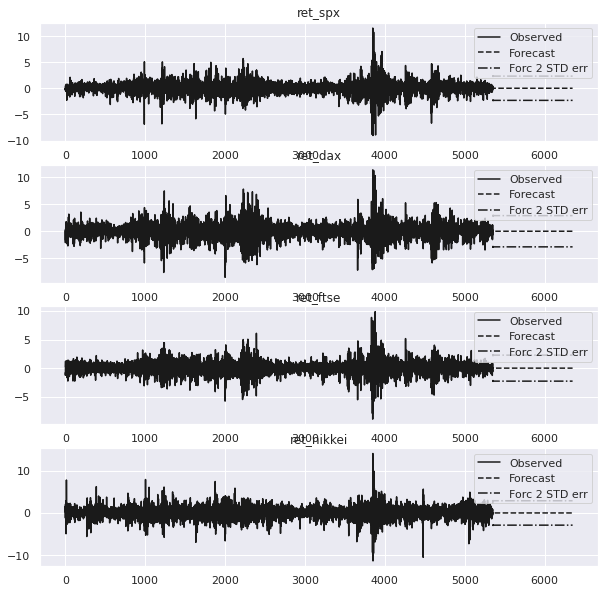

In [ ]:
results_var_ret.plot_forecast(1000)
plt.show()